In [1]:
import os
#os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

#import keras_cv
import keras
#from keras import ops
import tensorflow as tf
import keras_cv
import cv2
import pandas as pd
import numpy as np
from glob import glob
from scipy import signal
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt 

2024-03-28 12:03:52.979005: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 12:03:53.109750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


/home/dmoi/miniconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.14.0
Keras: 2.14.0
KerasCV: 0.8.2


# ⚙️ | Configuration

In [3]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [400, 300]  # Input image size
    epochs = 13 # Training epochs
    batch_size = 64  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [4]:
keras.utils.set_random_seed(CFG.seed)

# 📁 | Dataset Path 

In [5]:
BASE_PATH = ".."
SPEC_DIR = "../dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/train_eegs', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_eegs', exist_ok=True)

In [6]:

HMS_PATH = '/kaggle/input/hms-harmful-brain-activity-classification'
VER = 50
DATA_TYPE = 'KERFW' # K|E|R|KE|KR|ER|KER

USE_PROCESSED = True # Use processed downsampled Raw EEG 
submission = False

# 📖 | Meta Data 

In [7]:
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
HMS_PATH = '/kaggle/input/hms-harmful-brain-activity-classification'


def add_kl(data):
    labels = data[TARGETS].values + 1e-5
    data['kl'] = tf.keras.losses.KLDivergence(reduction='none')(
        np.array([[1/6]*6]*len(data)),labels)
    return data

if not submission:
    train = pd.read_csv('../train.csv')
    TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    META = ['spectrogram_id','spectrogram_label_offset_seconds','patient_id','expert_consensus']
    train = train.groupby('eeg_id')[META+TARGETS
                           ].agg({**{m:'first' for m in META},**{t:'sum' for t in TARGETS}}).reset_index() 
    train[TARGETS] = train[TARGETS]/train[TARGETS].values.sum(axis=1,keepdims=True)
    train.columns = ['eeg_id','spec_id','offset','patient_id','target'] + TARGETS
    train = add_kl(train)
    print(train.head(1).to_string())

   eeg_id    spec_id  offset  patient_id target  seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote        kl
0  568657  789577333     0.0       20654  Other           0.0       0.0      0.25        0.0   0.166667    0.583333  4.584192


In [8]:
%%time
if not submission:
    spectrograms = None
    all_eegs = None
    all_raw_eegs = None
    if DATA_TYPE in ['K','KE','KR','KER', 'KERFW']:
        spectrograms = np.load('../spectro_npy/specs.npy',allow_pickle=True).item()
    if DATA_TYPE in ['E','KE','ER','KER', 'KERFW']:
        all_eegs = np.load('../eeg_spectro_npy/eeg_specs.npy',allow_pickle=True).item()
    if DATA_TYPE in ['R','KR','ER','KER', 'KERFW']:
        if USE_PROCESSED:
            all_raw_eegs = np.load('../eeg_npy/eegs_processed.npy',allow_pickle=True).item()
        else:
            all_raw_eegs = np.load('../eeg_npy/eegs.npy',allow_pickle=True).item()

CPU times: user 322 ms, sys: 8.64 s, total: 8.96 s
Wall time: 9 s


In [9]:
def build_augmenter(dim=CFG.image_size):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # freq-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # time-masking
    ]    
    return augmenters

augmenters = build_augmenter()
def augment( data , augmenters= augmenters):
    for a in augmenters:
        data = a(data)
    return data


In [31]:
import albumentations as albu
from scipy.signal import butter, lfilter
from scipy.fft import fft

import librosa
    
FEATS2 = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS2,range(len(FEATS2)))}
FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]
    
class DataGenerator():
    'Generates data for Keras'
    def __init__(self, data, specs=None, eeg_specs=None, raw_eegs=None , augment=False, visualize = False, mode='train', data_type=DATA_TYPE): 
        self.data = data
        self.augment = augment
        self.mode = mode
        self.data_type = data_type
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.raw_eegs = raw_eegs
        self.visualize = visualize
        self.on_epoch_end()
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        X, y = self.data_generation(index)
        if self.augment: X = self.augmentation(X)
        return X, y
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            
            if i == self.__len__()-1:
                self.on_epoch_end()
                
    def on_epoch_end(self):
        if self.mode=='train': 
            self.data = self.data.sample(frac=1).reset_index(drop=True)
    
    def data_generation(self, index):
        if self.data_type == 'KE':
            X,y = self.generate_all_specs(index)
        elif self.data_type == 'E' or self.data_type == 'K':
            X,y = self.generate_specs(index)
        elif self.data_type == 'R':
            X,y = self.generate_raw(index)
        elif self.data_type in ['ER','KR']:
            X1,y = self.generate_specs(index)
            X2,y = self.generate_raw(index)
            X = (X1,X2)
        elif self.data_type in ['KER']:
            X1,y = self.generate_all_specs(index)
            X2,y = self.generate_raw(index)
            X = (X1,X2)
        elif self.data_type in ['KERFW']:
            
            X1,y = self.generate_all_specs(index)
            X2,y = self.generate_raw(index)
            X3,y = self.generate_fft(index)
            X4,y = self.generate_wavelet(index)
            X = (X1,X2,X3,X4)
        return X,y
    
    def generate_all_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        if self.mode=='test': 
            offset = 0
        else:
            offset = int(row.offset/2)
        
        eeg = self.eeg_specs[row.eeg_id]
        spec = self.specs[row.spec_id]
        
        imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in [0,2,1,3]] # to match kaggle with eeg
        img = np.stack(imgs,axis=-1)
        # LOG TRANSFORM SPECTROGRAM
        img = np.clip(img,np.exp(-4),np.exp(8))
        img = np.log(img)
            
        # STANDARDIZE PER IMAGE
        img = np.nan_to_num(img, nan=0.0)    
            
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        
        X[0_0+56:100+56,:256,0] = img[:,22:-22,0] # LL_k
        X[100+56:200+56,:256,0] = img[:,22:-22,2] # RL_k
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1] # LP_k
        X[100+56:200+56,:256,1] = img[:,22:-22,3] # RP_k
        X[0_0+56:100+56,:256,2] = img[:,22:-22,2] # RL_k
        X[100+56:200+56,:256,2] = img[:,22:-22,1] # LP_k
        
        X[0_0+56:100+56,256:,0] = img[:,22:-22,0] # LL_k
        X[100+56:200+56,256:,0] = img[:,22:-22,2] # RL_k
        X[0_0+56:100+56,256:,1] = img[:,22:-22,1] # LP_k
        X[100+56:200+56,256:,1] = img[:,22:-22,3] # RP_K
        
        # EEG
        img = eeg
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        X[200+56:300+56,:256,0] = img[:,22:-22,0] # LL_e
        X[300+56:400+56,:256,0] = img[:,22:-22,2] # RL_e
        X[200+56:300+56,:256,1] = img[:,22:-22,1] # LP_e
        X[300+56:400+56,:256,1] = img[:,22:-22,3] # RP_e
        X[200+56:300+56,:256,2] = img[:,22:-22,2] # RL_e
        X[300+56:400+56,:256,2] = img[:,22:-22,1] # LP_e
        
        X[200+56:300+56,256:,0] = img[:,22:-22,0] # LL_e
        X[300+56:400+56,256:,0] = img[:,22:-22,2] # RL_e
        X[200+56:300+56,256:,1] = img[:,22:-22,1] # LP_e
        X[300+56:400+56,256:,1] = img[:,22:-22,3] # RP_e

        if self.mode!='test':
            y[:] = row[TARGETS]
        
        return X,y
    
    def generate_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        if self.mode=='test': 
            offset = 0
        else:
            offset = int(row.offset/2)
            
        if self.data_type in ['E','ER']:
            img = self.eeg_specs[row.eeg_id]
        elif self.data_type in ['K','KR']:
            spec = self.specs[row.spec_id]
            imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in [0,2,1,3]] # to match kaggle with eeg
            img = np.stack(imgs,axis=-1)
            # LOG TRANSFORM SPECTROGRAM
            img = np.clip(img,np.exp(-4),np.exp(8))
            img = np.log(img)
            
            # STANDARDIZE PER IMAGE
            img = np.nan_to_num(img, nan=0.0)    
            
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        
        X[0_0+56:100+56,:256,0] = img[:,22:-22,0]
        X[100+56:200+56,:256,0] = img[:,22:-22,2]
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1]
        X[100+56:200+56,:256,1] = img[:,22:-22,3]
        X[0_0+56:100+56,:256,2] = img[:,22:-22,2]
        X[100+56:200+56,:256,2] = img[:,22:-22,1]
        
        X[0_0+56:100+56,256:,0] = img[:,22:-22,0]
        X[100+56:200+56,256:,0] = img[:,22:-22,1]
        X[0_0+56:100+56,256:,1] = img[:,22:-22,2]
        X[100+56:200+56,256:,1] = img[:,22:-22,3]
        
        X[200+56:300+56,:256,0] = img[:,22:-22,0]
        X[300+56:400+56,:256,0] = img[:,22:-22,1]
        X[200+56:300+56,:256,1] = img[:,22:-22,2]
        X[300+56:400+56,:256,1] = img[:,22:-22,3]
        X[200+56:300+56,:256,2] = img[:,22:-22,3]
        X[300+56:400+56,:256,2] = img[:,22:-22,2]
        
        X[200+56:300+56,256:,0] = img[:,22:-22,0]
        X[300+56:400+56,256:,0] = img[:,22:-22,2]
        X[200+56:300+56,256:,1] = img[:,22:-22,1]
        X[300+56:400+56,256:,1] = img[:,22:-22,3]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
        
        return X,y

    
    
    def generate_raw(self,index):
        if USE_PROCESSED and self.mode!='test':
            X = np.zeros((2_000,8),dtype='float32')
            y = np.zeros((6,),dtype='float32')
            row = self.data.iloc[index]
            X = self.raw_eegs[row.eeg_id]
            y[:] = row[TARGETS]
            return X,y
        
        X = np.zeros((10_000,8),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        eeg = self.raw_eegs[row.eeg_id]
            
        # FEATURE ENGINEER
        X[:,0] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['T3']]
        X[:,1] = eeg[:,FEAT2IDX['T3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,2] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['C3']]
        X[:,3] = eeg[:,FEAT2IDX['C3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,4] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['C4']]
        X[:,5] = eeg[:,FEAT2IDX['C4']] - eeg[:,FEAT2IDX['O2']]
            
        X[:,6] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['T4']]
        X[:,7] = eeg[:,FEAT2IDX['T4']] - eeg[:,FEAT2IDX['O2']]
            
        # STANDARDIZE
        X = np.clip(X,-1024,1024)
        X = np.nan_to_num(X, nan=0) / 32.0
            
        # BUTTER LOW-PASS FILTER
        X = self.butter_lowpass_filter(X)
        # Downsample
        X = X[::5,:]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
                
        return X,y

    def generate_fft(self,index,cutoff= 1000 ):
        if USE_PROCESSED and self.mode!='test':
            X = np.zeros((2_000,8),dtype='float32')
            y = np.zeros((6,),dtype='float32')
            row = self.data.iloc[index]
            X = self.raw_eegs[row.eeg_id]
            y[:] = row[TARGETS]
        else:        
            X = np.zeros((10_000,8),dtype='float32')
            y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        eeg = self.raw_eegs[row.eeg_id]
            
        # FEATURE ENGINEER
        X[:,0] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['T3']]
        X[:,1] = eeg[:,FEAT2IDX['T3']] - eeg[:,FEAT2IDX['O1']]
        
        X[:,2] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['C3']]
        X[:,3] = eeg[:,FEAT2IDX['C3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,4] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['C4']]
        X[:,5] = eeg[:,FEAT2IDX['C4']] - eeg[:,FEAT2IDX['O2']]
            
        X[:,6] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['T4']]
        X[:,7] = eeg[:,FEAT2IDX['T4']] - eeg[:,FEAT2IDX['O2']]
            
        # STANDARDIZE
        X = np.clip(X,-1024,1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        if self.visualize == True:
            # fft and split to real and imaginary
            X =  np.vstack([ fft( X[:cutoff , i] )  for i in range( X.shape[1] ) ] )
        else:
            X =  np.hstack([ fft( X[:cutoff , i] )  for i in range( X.shape[1] ) ] )
        X = np.hstack( [X.real ,  np.abs(X.imag) ])
        if self.mode!='test':
            y[:] = row[TARGETS]
        return X,y
    
    def generate_wavelet(self,index, cutoff= 1000 , start = 1 , stop=500, step = 10 , wavelet = signal.ricker):
        if USE_PROCESSED and self.mode!='test':
            X = np.zeros((2_000,8),dtype='float32')
            y = np.zeros((6,),dtype='float32')
            row = self.data.iloc[index]
            X = self.raw_eegs[row.eeg_id]
            y[:] = row[TARGETS]
        else:
            X = np.zeros((10_000,8),dtype='float32')
            y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        eeg = self.raw_eegs[row.eeg_id]

        # FEATURE ENGINEER
        X[:,0] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['T3']]
        X[:,1] = eeg[:,FEAT2IDX['T3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,2] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['C3']]
        X[:,3] = eeg[:,FEAT2IDX['C3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,4] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['C4']]
        X[:,5] = eeg[:,FEAT2IDX['C4']] - eeg[:,FEAT2IDX['O2']]
            
        X[:,6] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['T4']]
        X[:,7] = eeg[:,FEAT2IDX['T4']] - eeg[:,FEAT2IDX['O2']]

        # STANDARDIZE
        X = np.clip(X,-1024,1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # wavelet and make a downsampled image
        widths = np.arange(start,stop )
        cwtmatr = np.vstack( [  signal.cwt( X[:, i] , wavelet = wavelet, widths= widths) for i in range( X.shape[1] )  ]   )
        cwtmatr = np.dstack([ cwtmatr, cwtmatr ,cwtmatr ])
        
        X = cwtmatr
        if self.mode!='test':
            y[:] = row[TARGETS]
        return X,y
        
    def butter_lowpass_filter(self, data, cutoff_freq=20, sampling_rate=200, order=4):
        nyquist = 0.5 * sampling_rate
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        filtered_data = lfilter(b, a, data, axis=0)
        return filtered_data
    
    def resize(self, img,size):
        composition = albu.Compose([
                albu.Resize(size[0],size[1])
            ])
        return composition(image=img)['image']
            
    def augmentation(self, img):

        #add keras cv aug here
        
        composition = albu.Compose([
                albu.HorizontalFlip(p=0.4)
            ])
        return composition(image=img)['image']
        
def spectrogram_from_eeg(parquet_path):
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((100,300,4),dtype='float32')
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
            # FILL NANS
            x1 = eeg[COLS[kk]].values
            x2 = eeg[COLS[kk+1]].values
            m = np.nanmean(x1)
            if np.isnan(x1).mean()<1: x1 = np.nan_to_num(x1,nan=m)
            else: x1[:] = 0
            m = np.nanmean(x2)
            if np.isnan(x2).mean()<1: x2 = np.nan_to_num(x2,nan=m)
            else: x2[:] = 0
                
            # COMPUTE PAIR DIFFERENCES
            x = x1 - x2

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//300, 
                  n_fft=1024, n_mels=100, fmin=0, fmax=20, win_length=128)
            
            # LOG TRANSFORM
            width = (mel_spec.shape[1]//30)*30
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
          
    return img

def eeg_from_parquet(parquet_path):

    eeg = pd.read_parquet(parquet_path, columns=FEATS2)
    rows = len(eeg)
    offset = (rows-10_000)//2
    eeg = eeg.iloc[offset:offset+10_000]
    data = np.zeros((10_000,len(FEATS2)))
    for j,col in enumerate(FEATS2):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
        
        data[:,j] = x

    return data



/tmp/ipykernel_2777/3936163581.py:307: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwtmatr = np.vstack( [  signal.cwt( X[:, i] , wavelet = wavelet, widths= widths) for i in range( X.shape[1] )  ]   )
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(512, 512, 3)
(2000, 8)
(8, 2000)
(3992, 2000, 3)
(3992, 2000, 3)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


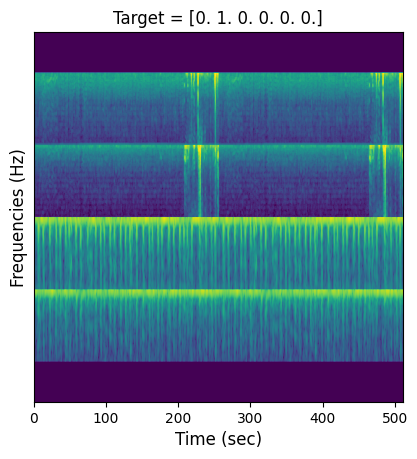

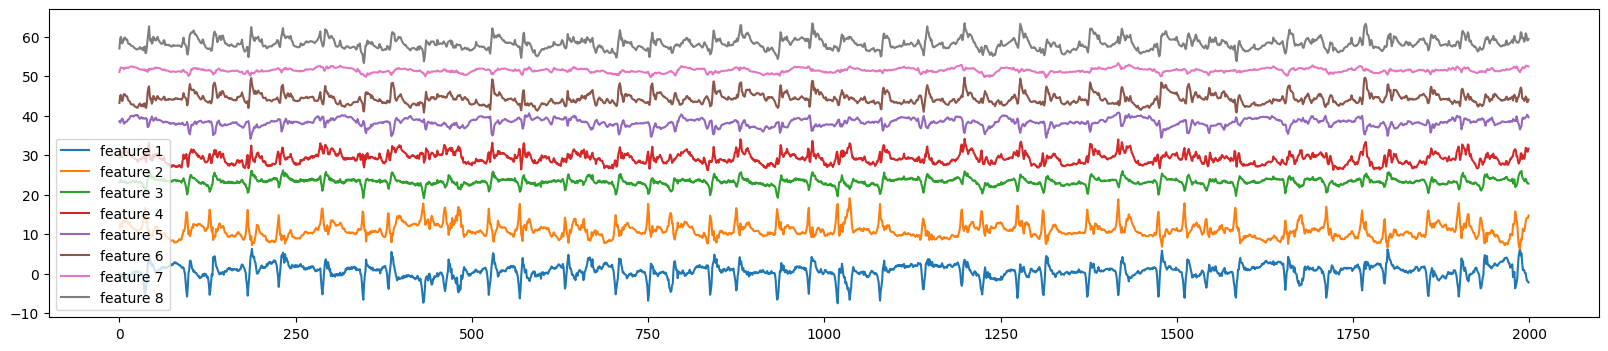

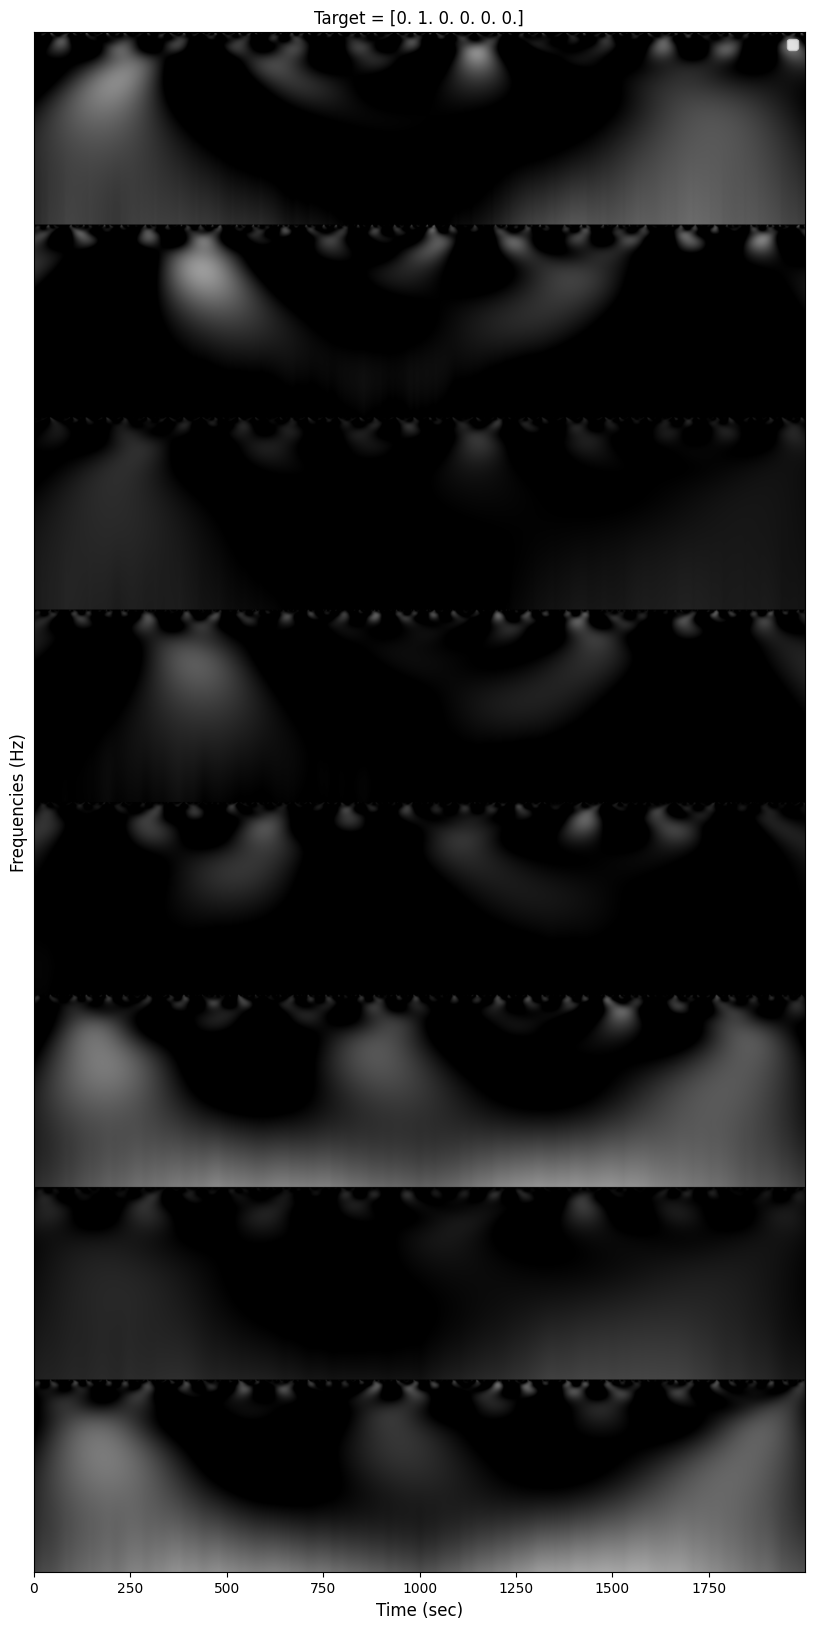

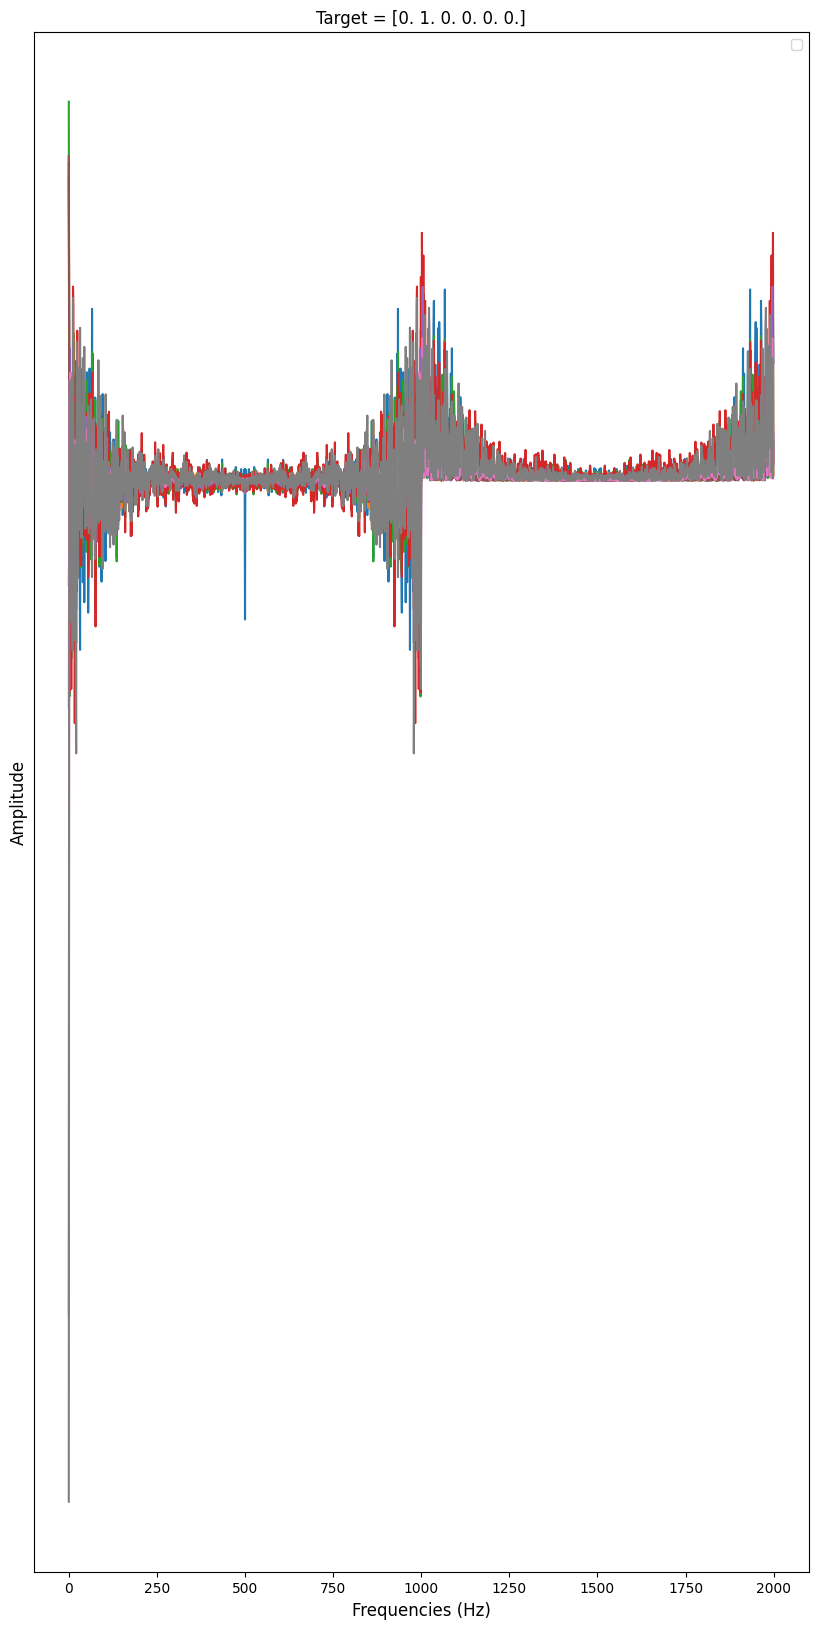

In [32]:
if not submission: 
    params = {'specs':spectrograms, 'eeg_specs':all_eegs, 'raw_eegs':all_raw_eegs }
    gen = DataGenerator(train, augment=False, visualize = True, **params)
    
    for x,y in gen:
        break

    for mat in x:
        print(mat.shape)
    
    if DATA_TYPE in ['E','K','KE','KR','ER','KER' , 'KERFW']:
        x1 = x[0] if DATA_TYPE in ['KR','ER','KER' ,'KERFW'] else x
        plt.imshow(x1[:,:,0])
        plt.title(f'Target = {y.round(1)}',size=12)
        plt.yticks([])
        plt.ylabel('Frequencies (Hz)',size=12)
        plt.xlabel('Time (sec)',size=12)
    
    if DATA_TYPE in ['R','KR','ER','KER',  'KERFW' ]:
        x1 = x[1] if DATA_TYPE in ['KR','ER','KER',  'KERFW' ] else x
        plt.figure(figsize=(20,4))
        offset = 0
        for j in range(x1.shape[-1]):
            if j!=0: offset -= x1[:,j].min()
            plt.plot(range(2_000),x1[:,j]+offset,label=f'feature {j+1}')
            offset += x1[:,j].max()
        plt.legend()
        
    if DATA_TYPE in [  'KERFW' ]:
        x1 = x[3] if DATA_TYPE in ['KERFW'] else x
        
        print(x1.shape)
        plt.figure(figsize=(20,20))
        plt.imshow(x1)
        plt.title(f'Target = {y.round(1)}',size=12)
        plt.yticks([])
        plt.ylabel('Frequencies (Hz)',size=12)
        plt.xlabel('Time (sec)',size=12)
        plt.legend()

    if DATA_TYPE in [  'KERFW' ]:
        x1 = x[2] if DATA_TYPE in ['KERFW'] else x
        plt.figure(figsize=(10,20))
        
        for row in range(x1.shape[0]):     
            plt.plot(x1[row,:])
        plt.title(f'Target = {y.round(1)}',size=12)
        plt.yticks([])
        plt.ylabel('Amplitude',size=12)
        plt.xlabel('Frequencies (Hz)',size=12)
        plt.legend()

        
    plt.show()
    

In [34]:
gen = DataGenerator(train, augment=False, **params)
print(gen)
for x,y in gen:
    break
print( [ xn.shape for xn in x ] )
print(y)

/tmp/ipykernel_2777/3936163581.py:307: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwtmatr = np.vstack( [  signal.cwt( X[:, i] , wavelet = wavelet, widths= widths) for i in range( X.shape[1] )  ]   )


[(512, 512, 3), (2000, 8), (16000,), (3992, 2000, 3)]
[0. 0. 0. 0. 1. 0.]


In [12]:
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate, LayerNormalization

"""
def build_model():
    K.clear_session()
    with strategy.scope():
        if DATA_TYPE in ['R']:
            model = build_wave_model()
        elif DATA_TYPE in ['K','E','KE']:
            model = build_spec_model()
        elif DATA_TYPE in ['KR','ER','KER']:
            model = build_hybrid_model()
    return model

def build_spec_model(hybrid=False):  
    inp = tf.keras.layers.Input((512,512,3))
    base_model = load_model(f'{LOAD_BACKBONE_FROM}')    
    x = base_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if not hybrid:
        x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer=opt)  
    return model

def wave_block(x, filters, kernel_size, n):
    dilation_rates = [2**i for i in range(n)]
    x = Conv1D(filters = filters,
               kernel_size = 1,
               padding = 'same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same', 
                          activation = 'tanh', 
                          dilation_rate = dilation_rate)(x)
        sigm_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid', 
                          dilation_rate = dilation_rate)(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = Add()([res_x, x])
    return res_x

def build_wave_model(hybrid=False):
        
    # INPUT 
    inp = tf.keras.Input(shape=(2_000,8))
    
    ############
    # FEATURE EXTRACTION SUB MODEL
    inp2 = tf.keras.Input(shape=(2_000,1))
    x = wave_block(inp2, 8, 4, 6)
    x = wave_block(x, 16, 4, 6)
    x = wave_block(x, 32, 4, 6)
    x = wave_block(x, 64, 4, 6)
    model2 = tf.keras.Model(inputs=inp2, outputs=x)
    ###########
    
    # LEFT TEMPORAL CHAIN
    x1 = model2(inp[:,:,0:1])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,1:2])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z1 = tf.keras.layers.Average()([x1,x2])
    
    # LEFT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,2:3])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,3:4])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z2 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,4:5])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,5:6])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z3 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT TEMPORAL CHAIN
    x1 = model2(inp[:,:,6:7])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,7:8])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z4 = tf.keras.layers.Average()([x1,x2])
    
    # COMBINE CHAINS
    y = tf.keras.layers.Concatenate()([z1,z2,z3,z4])
    if not hybrid:
        y = tf.keras.layers.Dense(64, activation='relu')(y)
        y = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(y)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=y)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

def build_hybrid_model():
    model_spec = build_spec_model(True)
    model_wave = build_wave_model(True)
    inputs = [model_spec.input, model_wave.input]
    x = [model_spec.output, model_wave.output]
    x = tf.keras.layers.Concatenate()(x)
    x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inputs, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

def score(y_true, y_pred):
    kl = tf.keras.metrics.KLDivergence()
    return kl(y_true, y_pred)

def plot_hist(hist):
    metrics = ['loss']
    for i,metric in enumerate(metrics):
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,i+1)
        plt.plot(hist[metric])
        plt.plot(hist[f'val_{metric}'])
        plt.title(f'{metric}',size=12)
        plt.ylabel(f'{metric}',size=12)
        plt.xlabel('epoch',size=12)
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()
        
def dataset(data, mode='train', batch_size=8, data_type=DATA_TYPE, 
            augment=False, specs=None, eeg_specs=None, raw_eegs=None):
    
    BATCH_SIZE_PER_REPLICA = batch_size
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    gen = DataGenerator(data,mode=mode, data_type=data_type, augment=augment,
                       specs=specs, eeg_specs=eeg_specs, raw_eegs=raw_eegs)
    if data_type in ['K','E','KE']: 
        inp = tf.TensorSpec(shape=(512,512,3), dtype=tf.float32)
    elif data_type in ['KR','ER','KER']:
        inp = (tf.TensorSpec(shape=(512,512,3), dtype=tf.float32),tf.TensorSpec(shape=(2000,8), dtype=tf.float32))
    elif data_type in ['R']:
        inp = tf.TensorSpec(shape=(2000,8), dtype=tf.float32)
        
    output_signature = (inp,tf.TensorSpec(shape=(6,), dtype=tf.float32))
    dataset = tf.data.Dataset.from_generator(generator=gen, output_signature=output_signature).batch(
        BATCH_SIZE)
    return dataset

def reset_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

"""

In [67]:
from keras.layers import Dense , BatchNormalization , Input ,GlobalAveragePooling2D , Flatten
from keras.losses import KLDivergence
from keras import Model

def wave_block(x, filters, kernel_size, n):
    dilation_rates = [2**i for i in range(n)]
    x = Conv1D(filters = filters,
               kernel_size = 1,
               padding = 'same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same', 
                          activation = 'tanh', 
                          dilation_rate = dilation_rate)(x)
        sigm_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid', 
                          dilation_rate = dilation_rate)(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = Add()([res_x, x])
    return res_x

modelspec = keras_cv.models.ImageClassifier.from_preset(
    "resnet50_imagenet",num_classes = 6
)

def resnet_block(x):
    modelspec = keras_cv.models.ImageClassifier.from_preset(
        "resnet50_imagenet",num_classes = 6
    )
    modelspec_out = modelspec.layers[-2].output  # This gets the layer before the output layer
    xspec = Dense(1024, activation='relu')(modelspec_out)
    model = Model(inputs=modelspec.input, outputs=modelspec_out)
    return model(x)

    
def buildmodel( ):
    Input_spec =  Input( (None, None, 3)  , name = 'spec_in')
    Input_wav =  Input( (None, None, 3) , name = 'wav_in')
    Input_fft = Input(  (16000 ) , name = 'fft_in' )
    #Input_stats = ( ( ) , name = 'stats_in' )

    Input_fft_n = BatchNormalization()(Input_fft)
    
    xwav =resnet_block(Input_wav)
    #aux0
    aux0 = Dense( 6 , activation = 'softmax' , name = 'aux0')(xwav)
    
    #wavelet transform
    xspec = resnet_block(Input_spec)
    
    aux1 = Dense( 6 , activation = 'softmax')(xspec)

    #dense fft 
    xfft = Dense( 1000 , activation = 'tanh')(Input_fft_n)
    xfft = Dense( 500 , activation = 'tanh')(xfft)
    xfft = Dense( 250 , activation = 'tanh')(xfft)
    fftout = Dense( 10 , activation = 'tanh')(xfft)
    aux2 = Dense( 6 , activation = 'softmax' , name= 'aux2')(xfft)
    
    xspec = Flatten()(xspec)
    xwav = Flatten()(xwav)
    
    integrate = keras.layers.Concatenate()( [ fftout, xspec , xwav ] )

    print(integrate)
    
    integrate = Dense( 1000 , activation = 'tanh')(integrate)
    integrate = Dense( 500 , activation = 'tanh')(integrate)
    integrate = Dense( 250 , activation = 'tanh')(integrate)

    #final classification
    final = Dense( 6 , activation = 'softmax' , name= 'aux')(integrate)
    
    lossfun = KLDivergence( )
    
    optimizer = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    name="adam",
    )
    
    #output
    model = keras.Model(
        inputs=[Input_spec,Input_wav,Input_fft], 
        outputs=[aux0, aux1, aux2, final],
         )
    model.compile( loss = lossfun, optimizer = optimizer , metrics=[
        'MeanSquaredError',
        'AUC',
        ])
    return model

model = buildmodel()



KerasTensor(type_spec=TensorSpec(shape=(None, 4106), dtype=tf.float32, name=None), name='concatenate_8/concat:0', description="created by layer 'concatenate_8'")


In [69]:
model.summary()

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fft_in (InputLayer)         [(None, 16000)]              0         []                            
                                                                                                  
 batch_normalization_35 (Ba  (None, 16000)                64000     ['fft_in[0][0]']              
 tchNormalization)                                                                                
                                                                                                  
 dense_108 (Dense)           (None, 1000)                 1600100   ['batch_normalization_35[0][0]
                                                          0         ']                            
                                                                                           

# ⚓ | LR Schedule

A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [16]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

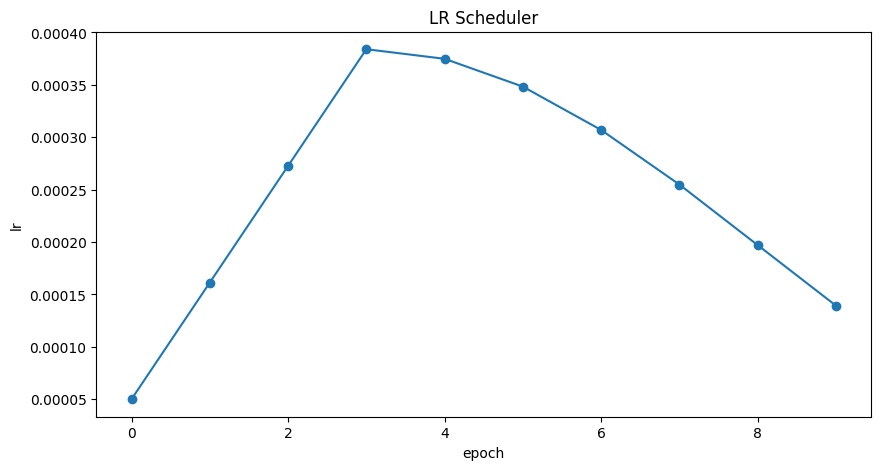

In [17]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=True)

# 💾 | Model Checkpointing

In [18]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.keras",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

# 🚂 | Training

In [ ]:
history = model.fit(
    train_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose
)

Epoch 1/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 150s 619ms/step - loss: 1.4366 - val_loss: 1.3616 - learning_rate: 5.0000e-05
Epoch 2/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 497ms/step - loss: 1.1419 - val_loss: 1.1242 - learning_rate: 1.6133e-04
Epoch 3/13
 63/143 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - loss: 1.0420

# 🧪 | Prediction

## Load Best Model

In [ ]:
model.load_weights("best_model.keras")

In [ ]:
if submission:
    test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
    print('Test shape',test.shape)
    test.head()


In [ ]:
# READ ALL SPECTROGRAMS
if submission:
    PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms'
    files2 = os.listdir(PATH2)
    print(f'There are {len(files2)} test spectrogram parquets')
    
    spectrograms2 = {}
    for i,f in enumerate(files2):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH2}/{f}')
        name = int(f.split('.')[0])
        spectrograms2[name] = tmp.iloc[:,1:].values
    
    # RENAME FOR DATA GENERATOR
    test = test.rename({'spectrogram_id':'spec_id'},axis=1)


In [ ]:
# READ ALL EEG SPECTROGRAMS
if submission:
    PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs'
    DISPLAY = 0
    EEG_IDS2 = test.eeg_id.unique()
    all_eegs2 = {}

    print('Converting Test EEG to Spectrograms...'); print()
    for i,eeg_id in enumerate(EEG_IDS2):
        
        # CREATE SPECTROGRAM FROM EEG PARQUET
        img = spectrogram_from_eeg(f'{PATH2}/{eeg_id}.parquet')
        all_eegs2[eeg_id] = img

In [ ]:
# READ ALL RAW EEG SIGNALS
if submission :
    all_raw_eegs2 = {}
    EEG_IDS2 = test.eeg_id.unique()
    PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs'

    print('Processing Test EEG parquets...'); print()
    for i,eeg_id in enumerate(EEG_IDS2):
        
        # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
        data = eeg_from_parquet(f'{PATH2}/{eeg_id}.parquet')
        all_raw_eegs2[eeg_id] = data


In [ ]:
# Submission ON TEST without ensemble
if submission and not ENSEMBLE:
    preds = []
    
    test_dataset = dataset(test,mode='test',specs=spectrograms2, eeg_specs=all_eegs2, raw_eegs=all_raw_eegs2)
    model = build_model()

    for i in range(5):
        print(f'Fold {i+1}')
        model.load_weights(f'{LOAD_MODELS_FROM}/model_{DATA_TYPE}_{VER}_{i}.weights.h5')
        pred = model.predict(test_dataset, verbose=1)
        preds.append(pred)
        
    pred = np.mean(preds,axis=0)
    print('Test preds shape',pred.shape)

In [ ]:
# Submission ON TEST with ensemble
if submission and ENSEMBLE:
    preds = []
    params = {'specs':spectrograms2, 'eeg_specs':all_eegs2, 'raw_eegs':all_raw_eegs2}
    test_dataset_K = dataset(test, data_type='K', mode='test', **params)
    test_dataset_E = dataset(test, data_type='E', mode='test', **params)
    test_dataset_R = dataset(test, data_type='R', mode='test', **params)
    test_dataset_KE = dataset(test, data_type='KE', mode='test', **params)
    test_dataset_KR = dataset(test, data_type='KR', mode='test', **params)
    test_dataset_ER = dataset(test, data_type='ER', mode='test', **params)
    test_dataset_KER = dataset(test, data_type='KER', mode='test', **params)

    # LB SCORE WEIGHTS FOR EACH MODEL
    lbs = 1 - np.array(LBs)
    weights = lbs/lbs.sum()
    model_spec = build_spec_model()
    model_wave = build_wave_model()
    model_hybrid = build_hybrid_model()
    
    for i in range(5):
        print(f'Fold {i+1}')
        
        model_spec.load_weights(f'{LOAD_MODELS_FROM}/model_K_{VER_K}_{i}.weights.h5')
        pred_K = model_spec.predict(test_dataset_K, verbose=1)
        
        model_spec.load_weights(f'{LOAD_MODELS_FROM}/model_E_{VER_E}_{i}.weights.h5')
        pred_E = model_spec.predict(test_dataset_E, verbose=1)

        model_wave.load_weights(f'{LOAD_MODELS_FROM}/model_R_{VER_R}_{i}.weights.h5')
        pred_R = model_wave.predict(test_dataset_R, verbose=1)
        
        model_spec.load_weights(f'{LOAD_MODELS_FROM}/model_KE_{VER_KE}_{i}.weights.h5')
        pred_KE = model_spec.predict(test_dataset_KE, verbose=1)
        
        model_hybrid.load_weights(f'{LOAD_MODELS_FROM}/model_KR_{VER_KR}_{i}.weights.h5')
        pred_KR = model_hybrid.predict(test_dataset_KR, verbose=1)
        
        model_hybrid.load_weights(f'{LOAD_MODELS_FROM}/model_ER_{VER_ER}_{i}.weights.h5')
        pred_ER = model_hybrid.predict(test_dataset_ER, verbose=1)
        
        model_hybrid.load_weights(f'{LOAD_MODELS_FROM}/model_KER_{VER_KER}_{i}.weights.h5')
        pred_KER = model_hybrid.predict(test_dataset_KER, verbose=1)
        
        pred = np.array([pred_K,pred_E,pred_R,pred_KE,pred_KR,pred_ER,pred_KER])
        pred = np.average(pred,axis=0,weights=weights)
        preds.append(pred)
        
    pred = np.mean(preds,axis=0)
    print('Test preds shape',pred.shape)


In [ ]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
if submission:
    print(sub.iloc[:,-6:].sum(axis=1).to_string())

## Build Test Dataset

In [ ]:
test_paths = test_df.spec2_path.values
test_ds = build_dataset(test_paths, batch_size=min(CFG.batch_size, len(test_df)),
                         repeat=False, shuffle=False, cache=False, augment=False)

## Inference

In [ ]:
preds = model.predict(test_ds)

# 📩 | Submission

In [ ]:
pred_df = test_df[["eeg_id"]].copy()
target_cols = [x.lower()+'_vote' for x in CFG.class_names]
pred_df[target_cols] = preds.tolist()

sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["eeg_id"]].copy()
sub_df = sub_df.merge(pred_df, on="eeg_id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

In [ ]:



import numpy as np
import pandas as pd
import pandas.api.types

import kaggle_metric_utilities

from typing import Optional


class ParticipantVisibleError(Exception):
    pass


def kl_divergence(solution: pd.DataFrame, submission: pd.DataFrame, epsilon: float, micro_average: bool, sample_weights: Optional[pd.Series]):
    # Overwrite solution for convenience
    for col in solution.columns:
        # Prevent issue with populating int columns with floats
        if not pandas.api.types.is_float_dtype(solution[col]):
            solution[col] = solution[col].astype(float)

        # Clip both the min and max following Kaggle conventions for related metrics like log loss
        # Clipping the max avoids cases where the loss would be infinite or undefined, clipping the min
        # prevents users from playing games with the 20th decimal place of predictions.
        submission[col] = np.clip(submission[col], epsilon, 1 - epsilon)

        y_nonzero_indices = solution[col] != 0
        solution[col] = solution[col].astype(float)
        solution.loc[y_nonzero_indices, col] = solution.loc[y_nonzero_indices, col] * np.log(solution.loc[y_nonzero_indices, col] / submission.loc[y_nonzero_indices, col])
        # Set the loss equal to zero where y_true equals zero following the scipy convention:
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.rel_entr.html#scipy.special.rel_entr
        solution.loc[~y_nonzero_indices, col] = 0

    if micro_average:
        return np.average(solution.sum(axis=1), weights=sample_weights)
    else:
        return np.average(solution.mean())


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        epsilon: float=10**-15,
        micro_average: bool=True,
        sample_weights_column_name: Optional[str]=None
    ) -> float:
    ''' The Kullback–Leibler divergence.
    The KL divergence is technically undefined/infinite where the target equals zero.

    This implementation always assigns those cases a score of zero; effectively removing them from consideration.
    The predictions in each row must add to one so any probability assigned to a case where y == 0 reduces
    another prediction where y > 0, so crucially there is an important indirect effect.

    https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

    solution: pd.DataFrame
    submission: pd.DataFrame
    epsilon: KL divergence is undefined for p=0 or p=1. If epsilon is not null, solution and submission probabilities are clipped to max(eps, min(1 - eps, p).
    row_id_column_name: str
    micro_average: bool. Row-wise average if True, column-wise average if False.

    Examples
    --------
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> score(pd.DataFrame({'id': range(4), 'ham': [0, 1, 1, 0], 'spam': [1, 0, 0, 1]}), pd.DataFrame({'id': range(4), 'ham': [.1, .9, .8, .35], 'spam': [.9, .1, .2, .65]}), row_id_column_name=row_id_column_name)
    0.216161...
    >>> solution = pd.DataFrame({'id': range(3), 'ham': [0, 0.5, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.9, 0, 0]})
    >>> submission = pd.DataFrame({'id': range(3), 'ham': [0, 0.5, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.9, 0, 0]})
    >>> score(solution, submission, 'id')
    0.0
    >>> solution = pd.DataFrame({'id': range(3), 'ham': [0, 0.5, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.9, 0, 0]})
    >>> submission = pd.DataFrame({'id': range(3), 'ham': [0.2, 0.3, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.7, 0.2, 0]})
    >>> score(solution, submission, 'id')
    0.160531...
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    sample_weights = None
    if sample_weights_column_name:
        if sample_weights_column_name not in solution.columns:
            raise ParticipantVisibleError(f'{sample_weights_column_name} not found in solution columns')
        sample_weights = solution.pop(sample_weights_column_name)

    if sample_weights_column_name and not micro_average:
        raise ParticipantVisibleError('Sample weights are only valid if `micro_average` is `True`')

    for col in solution.columns:
        if col not in submission.columns:
            raise ParticipantVisibleError(f'Missing submission column {col}')

    kaggle_metric_utilities.verify_valid_probabilities(solution, 'solution')
    kaggle_metric_utilities.verify_valid_probabilities(submission, 'submission')


    return kaggle_metric_utilities.safe_call_score(kl_divergence, solution, submission, epsilon=epsilon, micro_average=micro_average, sample_weights=sample_weights)

# 📌 | Reference
* [HMS-HBAC: ResNet34d Baseline [Training]](https://www.kaggle.com/code/ttahara/hms-hbac-resnet34d-baseline-training) 
* [EfficientNetB2 Starter - [LB 0.57]](https://www.kaggle.com/code/cdeotte/efficientnetb2-starter-lb-0-57)